In [1]:
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Problem 1

In [2]:
data=pd.read_csv('airpassenger.csv', index_col=0)

## Part a

#### We see evidence of a consistent, upward trend indicating a non-stationary process. However, the variance of the process seems mostly constant over time. At this point, there is not huge evidence of seasonality, but we will continue to look out for that.

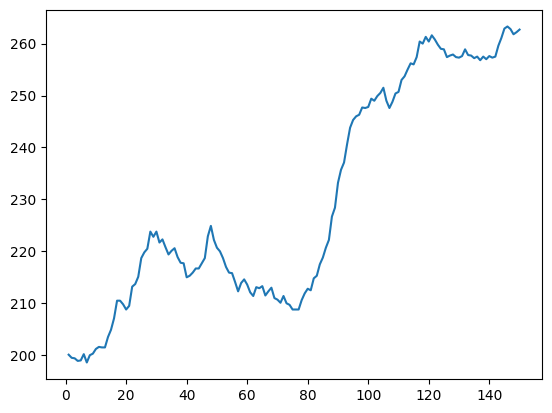

In [3]:
plt.plot(data)
plt.show()

## Part b

#### Now we can clearly see that there is evidence of seasonality with a period of 12 months.

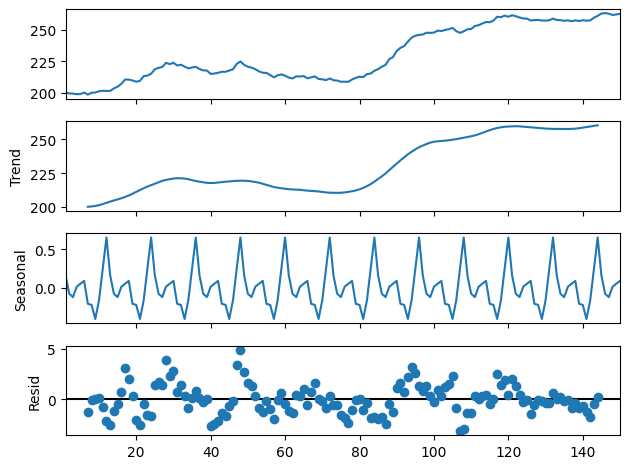

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, period=12)
result.plot();

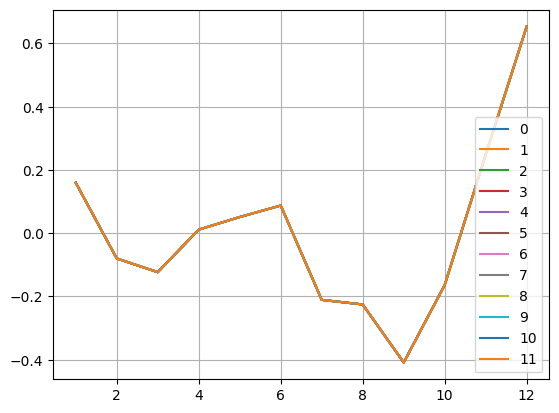

In [5]:
for j in range(12):
    plt.plot(range(1,13), result.seasonal[j*12:(j+1)*12], label=j)

plt.legend()
plt.grid()
plt.show()

^^^^ ?

## Part c

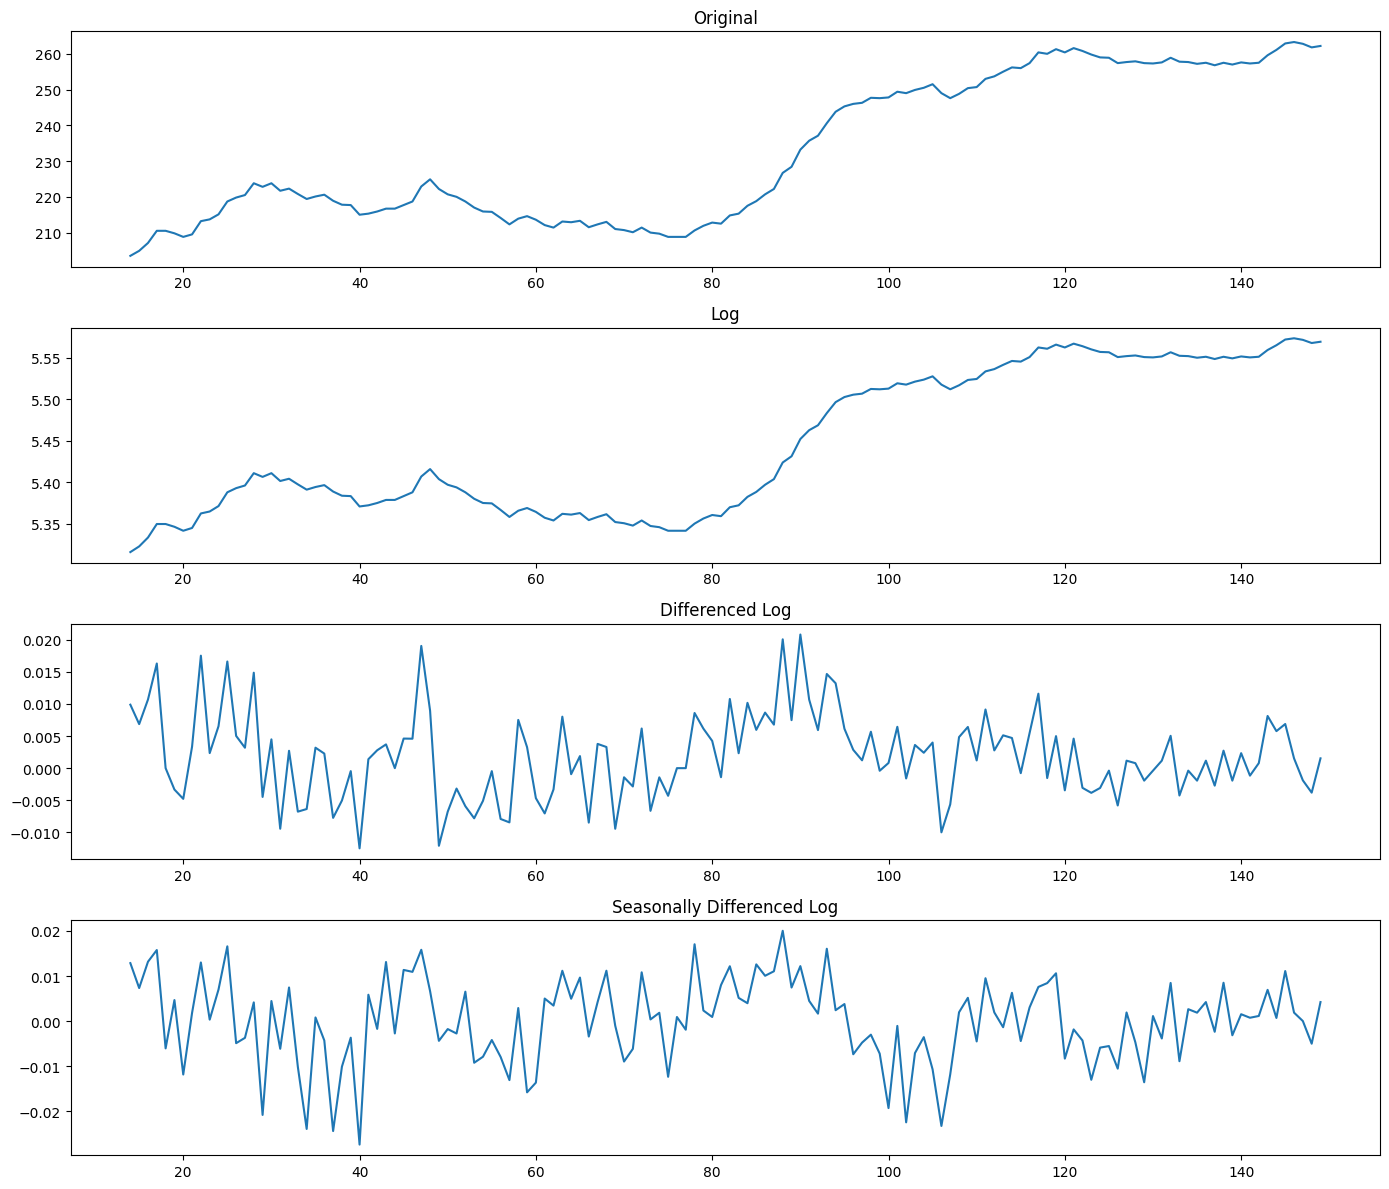

In [6]:
# Log Transform
log_data = np.log(data)
# Lag 1 differenced log data
dlog_data = log_data.diff()
# Lag 12 differenced lag 1 differenced log data
ddlog_data = dlog_data.diff(12)

combined_data = pd.DataFrame({
    'Original': data['x'],
    'Log': log_data['x'],
    'Differenced Log': dlog_data['x'],
    'Seasonally Differenced Log': ddlog_data['x']
}, index=range(len(data)))

# Drop NaN values that result from differencing
combined_data.dropna(inplace=True)

# Plotting
plt.figure(figsize=(14, 12))
for i, column in enumerate(combined_data.columns):
    plt.subplot(len(combined_data.columns), 1, i+1)
    plt.plot(combined_data.index, combined_data[column])
    plt.title(column)
    plt.tight_layout()

plt.show()

## Part d

We see that the ACF function has significant spikes at 1,2 and 3, while the PACF plot has significant spikes at 1 and 2.

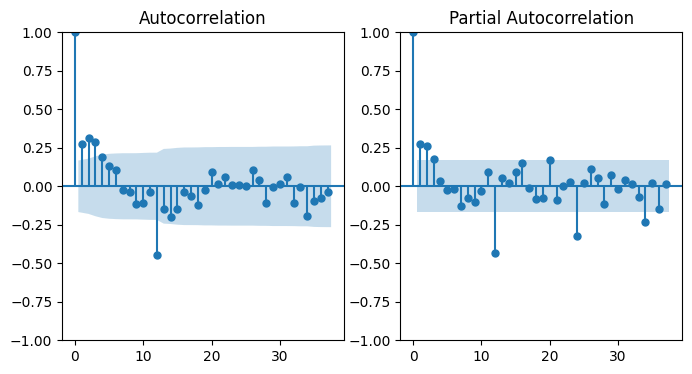

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2, figsize=(8,4))
plot_acf(ddlog_data.dropna(), ax=ax[0],lags=37);
plot_pacf(ddlog_data.dropna(), ax=ax[1], lags=37);

## Part e

From the plot below, the residuals of the ARMA(1,1) seems to be uncorrelated.

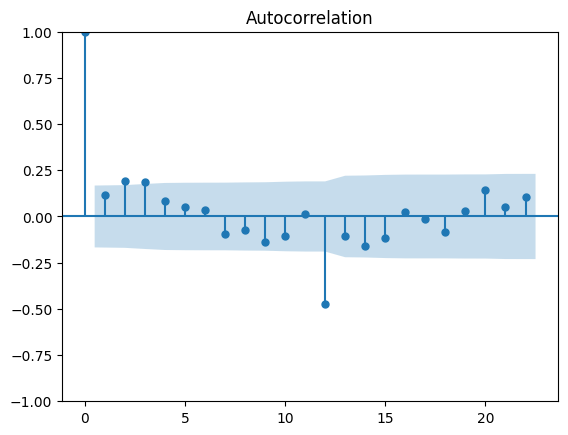

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ddlog_data.dropna().reset_index(drop=True), order=(1,0,1)).fit(disp=0);
plot_acf(model.resid);

## Part f

From the plot in part d, I will try the following models:

**Model 1**: 
- (p,d,q) = (2,1,3)
- (P,D,Q)s = (3,1,1)12

**Model 2**:
- (p,d,q) = (2,1,3)
- (P,D,Q)s = (2,1,1)12

The difference between them is whether to include the 3rd AR lag for the seasonal ARIMA model or not since it is very close to the CI for zero.

### Model 1

In [24]:
model_1 = SARIMAX(ddlog_data.dropna().reset_index(drop=True), order=(2,0,3), seasonal_order=(3,0,1,12)).fit(disp=0, max_iter=5000, method='powell')
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    x   No. Observations:                  137
Model:             SARIMAX(2, 0, 3)x(3, 0, [1], 12)   Log Likelihood                 491.526
Date:                              Tue, 05 Mar 2024   AIC                           -963.051
Time:                                      09:54:02   BIC                           -933.851
Sample:                                           0   HQIC                          -951.185
                                              - 137                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9124      1.054      0.866      0.387      -1.153       2.978
ar.L2         -0.1220      0.874     -0.140      0.889      -1.834       1.590
ma.L1         -0.7178      1.062     -0.676      0.499      -2.799       1.363
ma.L2          0.1248      0.676      0.185      0.854      -1.201       1.451
ma.L3          0.0726      0.125      0.581      0.561      -0.172       0.318
ar.S.L12       0.0251      0.222      0.113      0.910      -0.410       0.461
ar.S.L24      -0.0332      0.164     -0.202      0.840      -0.355       0.289
ar.S.L36      -0.0746      0.162     -0.461      0.645      -0.392       0.243
ma.S.L12      -0.9290      0.668     -1.392      0.164      -2.237       0.379
sigma2      3.778e-05   1.87e-05      2.020      0.043    1.12e-06    7.44e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.99   Prob(JB):                         0.80
Heteroskedasticity (H):               0.47   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

i) Unfortunately, none of the parameters are significant at a 95% confidence level.  
ii) The residuals seem stationary since they resemble white noise.  
iii) The residuals are uncorrelated, indicating that our model captures most of the autocorrelation in the data.  
iv) Yes, the standardized residuals seem to follow a gaussian distribution.  
v) We accept Ho that residuals are WN since p=.99

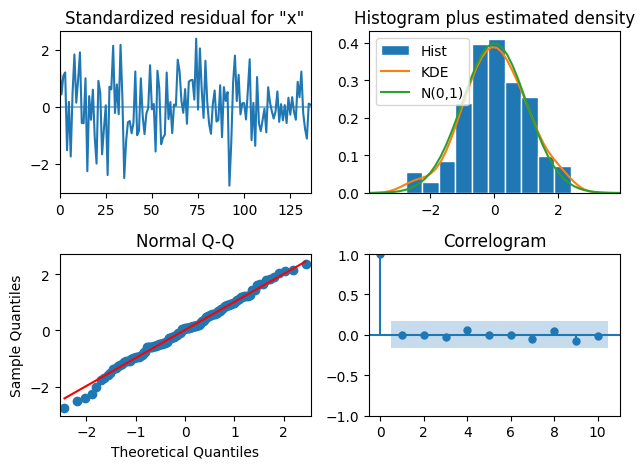

In [25]:
fig = plt.figure()
model_1.plot_diagnostics(fig=fig);
fig.tight_layout()

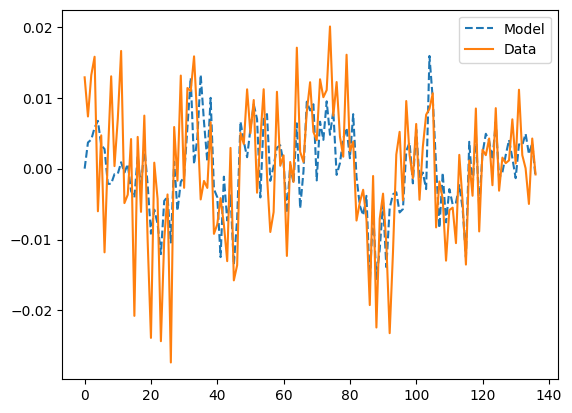

In [32]:
plt.plot(model_1.fittedvalues, label='Model', ls='--')
plt.plot(ddlog_data.dropna().reset_index(drop=True), label='Data')
plt.legend()
plt.show()

### Model 2

In [34]:
model_2 = SARIMAX(ddlog_data.dropna().reset_index(drop=True), order=(0,0,0), seasonal_order=(3,0,1,12)).fit(disp=0, max_iter=5000, method='powell')
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          x   No. Observations:                  137
Model:             SARIMAX(3, 0, [1], 12)   Log Likelihood                 480.945
Date:                    Tue, 05 Mar 2024   AIC                           -951.890
Time:                            09:56:41   BIC                           -937.290
Sample:                                 0   HQIC                          -945.957
                                    - 137                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0107      0.206      0.052      0.959      -0.394       0.415
ar.S.L24      -0.0360      0.155     -0.232      0.816      -0.339       0.267
ar.S.L36      -0.1779      0.144     -1.237      0.216      -0.460       0.104
ma.S.L12      -0.9584      1.275     -0.752      0.452      -3.458       1.541
sigma2      4.188e-05   4.54e-05      0.923      0.356    -4.7e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                  12.28   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               0.41   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

i) No parameters are significant.  
ii) The plot of the residuals looks similar to White Noise but less random/more correlation.  
iii) We can see that some residuals are correlated.  
iv) The standarized residuals seem to be normally distributed.  
v) We must reject the Ho that the residuals are WN b/c p=0.00.

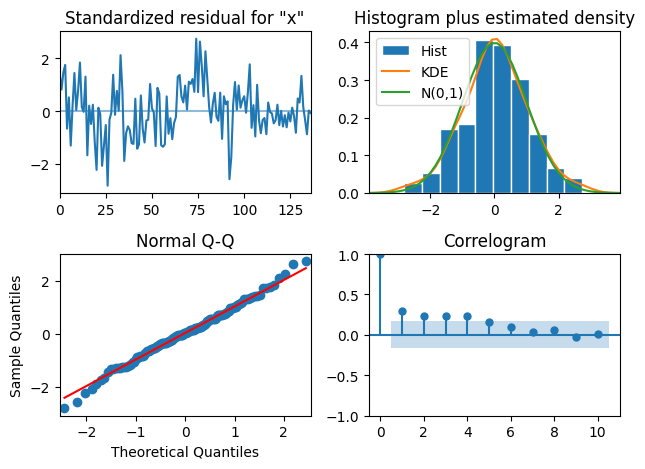

In [35]:
fig = plt.figure()
model_2.plot_diagnostics(fig=fig);
fig.tight_layout()

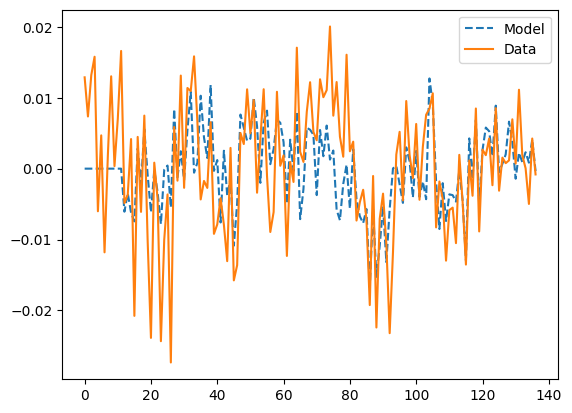

In [36]:
plt.plot(model_2.fittedvalues, label='Model', ls='--')
plt.plot(ddlog_data.dropna().reset_index(drop=True), label='Data')
plt.legend()
plt.show()

vi) The second model has the lowest information criterion, however, it is important to consider that it failed the Ljung-Box text, indicating that its residuals are not WN and likely correlated.

## Part g

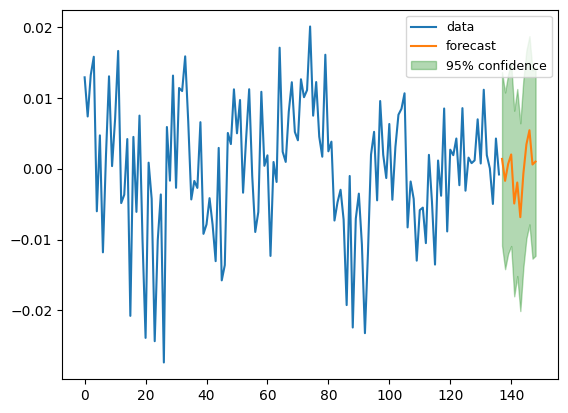

In [58]:
forecast_object = model_1.get_forecast(steps=12)
forecast = forecast_object.predicted_mean
lower_bound = forecast_object.conf_int()['lower x']
upper_bound = forecast_object.conf_int()['upper x']

plt.plot(ddlog_data.dropna().reset_index(drop=True).index, ddlog_data.dropna().reset_index(drop=True), label='data')
plt.plot(forecast.index, forecast, label='forecast')
plt.fill_between(forecast.index, lower_bound, upper_bound, color='green', alpha=0.3, label='95% confidence')
plt.legend(fontsize=9)
plt.show()

Yes the forecast seems reasonable based on recent trends.